# Price Forecasting for Automobiles

#### by Sooyeon Won 

### Keywords 
- A practical project with real-world data
- Analytics Framework 
- Linear Regression 
- Data Visualisation 

### Contents 

<ul>
<li><a href="#Preprocessing">1. Preprocessing</a></li>
<li><a href="#Assumptions">2. Checking the OLS assumptions</a></li>
<li><a href="#Regression">3. Linear Regression Model</a></li>
<li><a href="#Testing">4. Testing</a></li>
<li><a href="#Conclusion">5. Conclusion</a></li>
</ul>

In [1]:
# Importing the relevant libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [2]:
# Load the data from a .csv in the same folder
raw_data = pd.read_csv('01_automobile_data.csv')

# Explore the top 5 rows of the dataframe
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


<a id='Preprocessing'></a>
## 1. Preprocessing

#### Exploring the descriptive statistics of the variables

> - Descriptive statistics are very useful for initial exploration of the variables. 
> - By default, only descriptives for the numerical variables are shown.
> - To include the categorical ones, we should specify this with an argument.
> - Note that categorical variables don't have some types of numerical descriptives and numerical variables don't have some types of categorical descriptives

In [3]:
raw_data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


#### Determining the variables of interest

In [4]:
# The column seems to have low variation. -> decided to drop
data = raw_data.drop(['Model'],axis=1)

#### Dealing with missing values

In [5]:
# This will give us the total number of missing values feature-wise
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [6]:
# Simply drop all missing values
# Rule of Thumb: drop the missing data if they are less than 5% of the data
data_no_mv = data.dropna(axis=0)

# axis = 0: rows 
# axis = 1: columns

In [7]:
# To check the descriptives without the missing values
data_no_mv.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,4025,4025.000000,4025,4025.000000,4025.000000,4025,4025,4025.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,880,NaN,1534,NaN,NaN,1861,3654,NaN
mean,NaN,19552.308065,NaN,163.572174,2.764586,NaN,NaN,2006.379627
std,NaN,25815.734988,NaN,103.394703,4.935941,NaN,NaN,6.695595
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000
75%,NaN,21900.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000


#### Exploring the PDFs by Seaborn

- A great step in the data exploration is to display the probability distribution function (PDF) of a variable. 
- The PDF will show us how that variable is distributed. 
- This makes it very easy to spot anomalies, such as outliers. 
- The PDF is often the basis on which we decide whether we want to transform a feature.


C:\Users\wonso\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

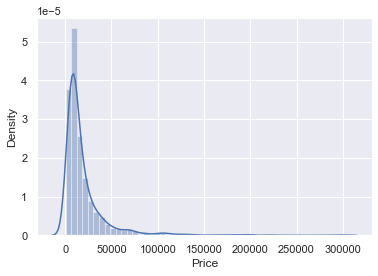

In [8]:
sns.distplot(data_no_mv['Price'])

#### Dealing with outliers

- Obviously there are some outliers present. 
- We can deal with the problem easily by removing 0.5%, or 1% of the problematic samples. 
- The outliers are situated around the higher prices (right side of the graph). Logical thinking , this is a dataset about used cars, and $300,000 is an excessive price for used cars. 
- It may be a useful exercise to try training a model without removing the outliers



In [9]:
# To declare a variable that will be equal to the 99th percentile of the 'Price' variable
q = data_no_mv['Price'].quantile(0.99)
# Then create a new df, with the condition that all prices must be below the 99 percentile of 'Price'.
# In this way we have essentially removed the top 1% of the data about 'Price'
data_1 = data_no_mv[data_no_mv['Price']<q]

#### Other numerical variables

#### Mileage

Text(0.5, 1.0, 'Price data without Outliers')

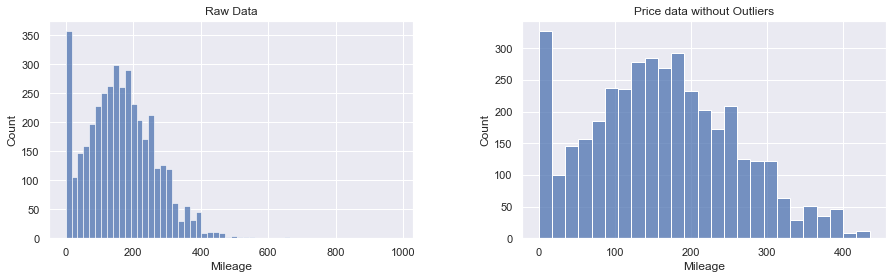

In [10]:
plt.figure(figsize=[15,4]) 
plt.subplots_adjust(wspace = 0.3 , hspace= 0.1)

plt.subplot(1, 2, 1)
sns.histplot(data_no_mv['Mileage'])
plt.title('Raw Data')

q = data_1['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage']<q]

plt.subplot(1, 2, 2)
sns.histplot(data_2['Mileage'])
plt.title('Price data without Outliers')

#### Engine Volumne

Text(0.5, 1.0, ' Engine Volumne data without Outliers')

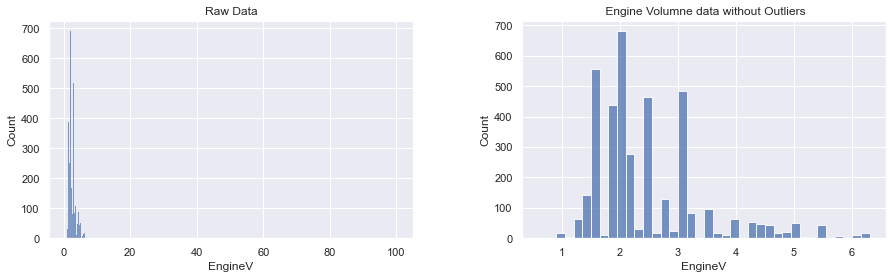

In [11]:
plt.figure(figsize=[15,4]) 
plt.subplots_adjust(wspace = 0.3 , hspace= 0.1)

plt.subplot(1, 2, 1)
sns.histplot(data_no_mv['EngineV'])
plt.title('Raw Data')

data_3 = data_2[data_2['EngineV']<6.5]

plt.subplot(1, 2, 2)
sns.histplot(data_3['EngineV']) 
plt.title(' Engine Volumne data without Outliers')

**Comments:**
- In such cases it makes sense to manually check (Google search to find the natural domain of this variable) what may be causing the problem. The dataset has the issue which comes from the fact that most missing values are indicated with 99.99 or 99. 
- There are also some incorrect entries like 75.
- Car engine volumes are usually below 6.5l. This is a prime example of the fact that a domain expert (a person working in the car industry).
- Following this graph on the right, we can actually treat the feature: EngineV as a categorical variable. However I treat it as a numerical variable in this analysis.

#### Year
- Finally, the situation with 'Year' is similar to 'Price' and 'Mileage'. 
- However, the outliers are on the low end. 

Text(0.5, 1.0, ' Year without Outliers')

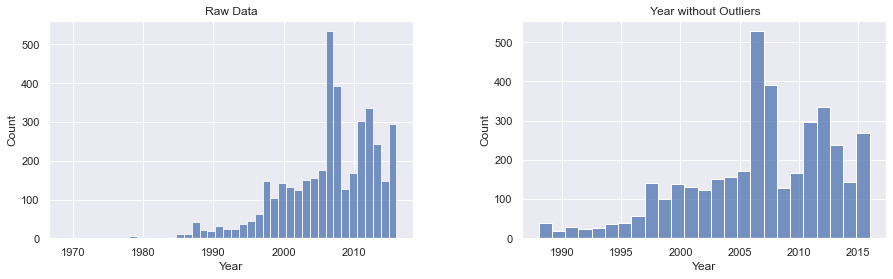

In [12]:
plt.figure(figsize=[15,4]) 
plt.subplots_adjust(wspace = 0.3 , hspace= 0.1)

plt.subplot(1, 2, 1)
sns.histplot(data_no_mv['Year'])
plt.title('Raw Data')

# Set the quantile
q = data_3['Year'].quantile(0.01)
data_4 = data_3[data_3['Year']>q]

plt.subplot(1, 2, 2)
sns.histplot(data_4['Year']) 
plt.title(' Year without Outliers')

- By filtering observations, the original indexes are preserved. It is better to reset the indices. 
- Once we reset the index, a new column will be created containing the old index (just in case)
- Sine I do not need it, thus 'drop=True' to completely forget about it

In [13]:
data_cleaned = data_4.reset_index(drop=True)
data_cleaned.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3867,3867.000000,3867,3867.000000,3867.000000,3867,3867,3867.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,848,NaN,1467,NaN,NaN,1807,3505,NaN
mean,NaN,18194.455679,NaN,160.542539,2.450440,NaN,NaN,2006.709853
std,NaN,19085.855165,NaN,95.633291,0.949366,NaN,NaN,6.103870
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000
25%,NaN,7200.000000,NaN,91.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11700.000000,NaN,157.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21700.000000,NaN,225.000000,3.000000,NaN,NaN,2012.000000


<a id='Assumptions'></a>
## 2. Checking the OLS assumptions

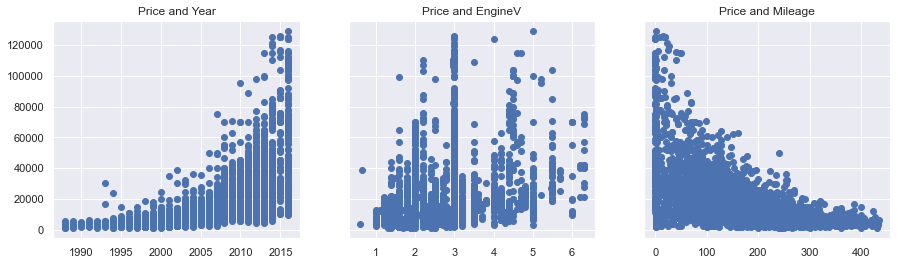

In [14]:
# With scatter plots, we can figure the relationships between price and input features: year, engine volumn, mileage
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,4)) #sharey -> share 'Price' as y
ax1.scatter(data_cleaned['Year'],data_cleaned['Price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['Price'])
ax2.set_title('Price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['Price'])
ax3.set_title('Price and Mileage')

plt.show()

- From the subplots and the PDF of price, we can easily determine that 'Price' is exponentially distributed. 
- A good transformation in that case is a log transformation.

### Relaxing the assumptions

#### Linearity

In [15]:
# Transform 'Price' with a log transformation
log_price = np.log(data_cleaned['Price'])

# Add it to the data frame
data_cleaned['log_price'] = log_price
data_cleaned

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,log_price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,9.814656
...,...,...,...,...,...,...,...,...,...
3862,Volkswagen,11500.0,van,163,2.5,Diesel,yes,2008,9.350102
3863,Toyota,17900.0,sedan,35,1.6,Petrol,yes,2014,9.792556
3864,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014,11.736069
3865,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999,8.779557


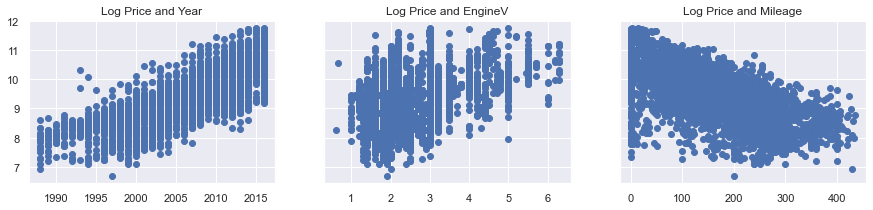

In [16]:
# Check the three scatters once again
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax1.scatter(data_cleaned['Year'],data_cleaned['log_price'])
ax1.set_title('Log Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['log_price'])
ax2.set_title('Log Price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['log_price'])
ax3.set_title('Log Price and Mileage')


plt.show()


- The relationships show a clear linear relationship (Alternatively we could have transformed each of the independent variables).

In [17]:
# Since we will be using the log price variable, I droped the column 'Price'
data_cleaned = data_cleaned.drop(['Price'], axis=1)

#### Multicollinearity

In [18]:
# To see the columns of the data frame
data_cleaned.columns.values 

array(['Brand', 'Body', 'Mileage', 'EngineV', 'Engine Type',
       'Registration', 'Year', 'log_price'], dtype=object)

In [19]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# variables I want to check for multicollinearity (numerical variables only)
variables = data_cleaned[['Mileage','Year','EngineV']]

# Create a new data frame which will include all the VIFs
# Note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif["Features"] = variables.columns

vif

,VIF,Features
0,3.791584,Mileage
1,10.354854,Year
2,7.662068,EngineV


- Since 'Year' has the highest VIF, I removed it from the model.
- This drives the VIF of other variables down. Even if EngineV seems with a high VIF, too, once 'Year' is gone that will no longer be the case.

In [20]:
data_no_multicollinearity = data_cleaned.drop(['Year'],axis=1)

### Create dummy variables & Rearrange

In [21]:
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first=True)
data_with_dummies.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,427,2.9,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,358,5.0,9.495519,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,240,4.2,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,120,2.0,9.814656,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


- To include the categorical data in the regression, I created dummies using pandas's 'get_dummies.
- I dropped one of the dummies, to avoid multicollinearity.

In [22]:
# Rearrange the columns : to place the dependent variable in the beginning of the df
data_with_dummies.columns.values

array(['Mileage', 'EngineV', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype=object)

In [23]:
cols = ['log_price', 'Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']

# To implement the reordering, I created a new df, which is equal to the old one but with the new order of features

data_preprocessed = data_with_dummies[cols]

<a id='Regression'></a>
## 3. Linear Regression Model

### Declare the inputs and the targets

In [24]:
# The target(s) (dependent variable) is 'log price'
targets = data_preprocessed['log_price']

# The inputs are everything BUT the dependent variable, so I simply dropped it
inputs = data_preprocessed.drop(['log_price'],axis=1)

### Scale the data

In [25]:
# Import the scaling module
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()
# Fit the inputs (calculate the mean and standard deviation feature-wise)
scaler.fit(inputs)

StandardScaler()

In [26]:
# Scale the features and store them in a new variable (the actual scaling procedure)
inputs_scaled = scaler.transform(inputs)

### Train Test Split

In [27]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with an 80-20 split and some random state
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=42)

### Create the regression

In [28]:
# Create a linear regression object
reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)

LinearRegression()

In [29]:
# Check the outputs of the regression
# Store them in y_hat as the predictions
y_hat = reg.predict(x_train)

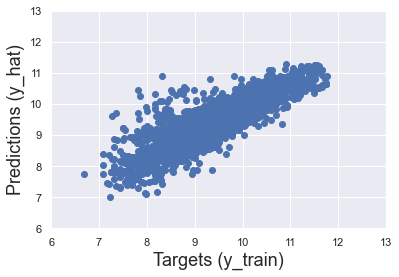

In [30]:
plt.scatter(y_train, y_hat)

plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)

# By setting the x-axis and the y-axis to be the identical, I scaled equally both axises
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

**Comments:**
- The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot both of them on a scatter plot
- The closer the points to the 45-degree line, the better the prediction

#### Residual Plot
- I plotted the PDF of the residuals and checked for anomalies

Text(0.5, 1.0, 'Residuals PDF')

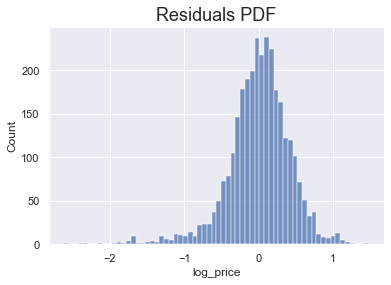

In [31]:
sns.histplot(y_train - y_hat)
plt.title("Residuals PDF", size=18)

- For the best case scenario, this plot should be normally distributed. In this analysis, we can notice many negative residuals (far away from the mean). 
- Given the definition of the residuals (y_train - y_hat), negative values imply that y_hat (predictions) are much higher than y_train (the targets).

In [32]:
# The R-squared of the model
reg.score(x_train,y_train)

0.7546487921881218

### Finding the weights and bias

In [33]:
# Obtain the bias (intercept) of the regression
reg.intercept_

9.421003614148074

In [34]:
# Obtain the weights (coefficients) of the regression
reg.coef_

# Note that they are barely interpretable if at all

array([-0.46815598,  0.21526817,  0.01105151,  0.00569157, -0.14247174,
       -0.18769337, -0.06529696, -0.09898873, -0.13980763, -0.09384461,
       -0.17892753, -0.11457574, -0.15668036, -0.11685263, -0.02572253,
       -0.15106183,  0.31442123])

In [35]:
# Create a regression summary where we can compare them with one-another
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,Mileage,-0.468156
1,EngineV,0.215268
2,Brand_BMW,0.011052
3,Brand_Mercedes-Benz,0.005692
4,Brand_Mitsubishi,-0.142472
5,Brand_Renault,-0.187693
6,Brand_Toyota,-0.065297
7,Brand_Volkswagen,-0.098989
8,Body_hatch,-0.139808
9,Body_other,-0.093845


In [36]:
# Check the different categories in the 'Brand' variable
data_cleaned['Brand'].unique()

# In this way we can see which 'Brand' is actually the benchmark

array(['BMW', 'Mercedes-Benz', 'Audi', 'Toyota', 'Renault', 'Volkswagen',
       'Mitsubishi'], dtype=object)

<a id='Testing'></a>
## 4. Testing

In [37]:
# Predict the test input data
y_hat_test = reg.predict(x_test)

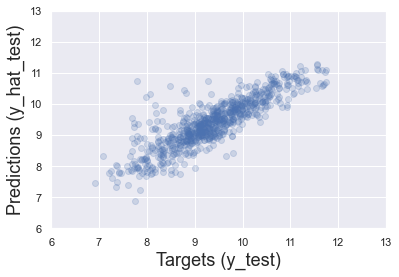

In [38]:
# Create a scatter plot with the test targets and the test predictions
plt.scatter(y_test, y_hat_test, alpha=0.2) # 'alpha':opacity to the graph
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [39]:
# I manually checked the predictions
# We should take the exponential of the log_price to obtain the actual prices
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,40419.308971
1,7956.895960
2,5757.284408
3,9765.810605
4,7027.363814


In [40]:
# To get a proper result, I reset the index and drop the old indexing.
y_test = y_test.reset_index(drop=True)

y_test.head()

0    9.966462
1    9.093807
2    8.086410
3    9.392662
4    8.594154
Name: log_price, dtype: float64

In [41]:
# I overwrote the 'Target' column with the appropriate values
# Again, I need the exponential of the test log price
df_pf['Target'] = np.exp(y_test)
df_pf

,Prediction,Target
0,40419.308971,21300.0
1,7956.895960,8900.0
2,5757.284408,3250.0
3,9765.810605,12000.0
4,7027.363814,5400.0
...,...,...
769,4699.586013,4200.0
770,9123.067372,8800.0
771,6267.803094,4850.0
772,20906.128600,27000.0


In [42]:
# Since OLS is basically an algorithm which minimizes the total sum of squared errors (residuals), I compute the residuals.

# Residual
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [43]:
# I calculate the absolute difference in %, to see how far off we are from the result percentage-wise.
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

,Prediction,Target,Residual,Difference%
0,40419.308971,21300.0,-19119.308971,89.762014
1,7956.895960,8900.0,943.104040,10.596675
2,5757.284408,3250.0,-2507.284408,77.147213
3,9765.810605,12000.0,2234.189395,18.618245
4,7027.363814,5400.0,-1627.363814,30.136367
...,...,...,...,...
769,4699.586013,4200.0,-499.586013,11.894905
770,9123.067372,8800.0,-323.067372,3.671220
771,6267.803094,4850.0,-1417.803094,29.233053
772,20906.128600,27000.0,6093.871400,22.569894


In [44]:
# Exploring the descriptives here gives us additional insights
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,774.000000,774.000000,774.000000,774.000000
mean,16113.011638,17799.988992,1686.977355,42.085282
std,13326.229797,19723.434542,11192.614496,96.169928
min,967.030415,999.000000,-42859.020603,0.020246
25%,7467.591694,6700.000000,-2246.354353,11.024941
50%,11914.358989,11050.000000,-38.697776,24.086183
75%,20249.505640,20475.000000,3004.524837,42.381716
max,79026.348020,125000.000000,81051.158885,1785.792525


In [45]:
# To see all rows, we use the relevant pandas syntax
pd.options.display.max_rows = 999

# Moreover, to make the dataset clear, I display the result with only 2 digits after the dot 
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Finally, I sort by difference in % and manually check the model
df_pf.sort_values(by=['Difference%']).head(10)

,Prediction,Target,Residual,Difference%
387,13602.75,13600.00,-2.75,0.02
74,28889.06,28900.00,10.94,0.04
314,35530.21,35500.00,-30.21,0.09
336,11313.27,11300.00,-13.27,0.12
425,2995.68,3000.00,4.32,0.14
262,52180.11,52055.25,-124.86,0.24
674,3107.51,3100.00,-7.51,0.24
648,9675.57,9700.00,24.43,0.25
79,21407.59,21335.00,-72.59,0.34
313,9865.72,9900.00,34.28,0.35


In [46]:
df_pf.sort_values(by=['Difference%']).tail(10)

,Prediction,Target,Residual,Difference%
747,10572.99,2300.00,-8272.99,359.70
562,31429.04,6800.00,-24629.04,362.19
58,11913.91,2300.00,-9613.91,418.00
260,33893.01,6500.00,-27393.01,421.43
556,20887.21,3500.00,-17387.21,496.78
713,13941.93,2200.00,-11741.93,533.72
280,39469.51,4800.00,-34669.51,722.28
219,27632.40,2900.00,-24732.40,852.84
750,30076.59,3150.00,-26926.59,854.81
681,45259.02,2400.00,-42859.02,1785.79


<a id='Conclusion'></a>
## 5. Conclusion

- Revising this data frame manually we could see for which types of observations I have obtained good predictions and for which we are very far off.
<br>
- It is particularly interesting to investigate the predictions that have the biggest differences.
<br>
- From the last output, we see that there are very few predictions dramatically far from the observed values. The observed prices are extremely low, but the predicted price is very high. 
<br>
- In this analysis, the mileage engine volume brand registration and body type are used to predict the price of a used car. In general, it is pretty decent at predicting the price. For these last samples though, it played not an important role. Remember that all residuals for these outliers are negative. Therefore their predictions are higher than the targets.
<br>
- One explanation may be that we are missing an important factor which drives the price of a used car lower. It may be the model of the car which we remove at the beginning of the analysis but it may also be that the car was damaged in some way. This sort of information we did not initially have.